# **Tema 2: Procesamiento de imágenes digitales. Operaciones de filtrado espacial (lineales y no lineales)** 


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## **Operaciones de filtrado en el dominio espacial** 

Cuando vamos a realizar una convolución, el kernel o máscara que nos proporcionan es una matriz (np.array en nuestro caso). Si queremos hacer una convolución utilizando la implementación de la operación de correlación, como la que nos proporciona OpenCV en [cv2.filter2D](https://docs.opencv.org/4.6.0/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04), tendremos que voltear la máscara verticalmente y horizontalmente (np.flip) y utilizar el resultado como máscara de correlación:

In [2]:
kernel = np.array([[1, 2, 3], 
                   [4, 5, 6], 
                   [7, 8, 9]])
print("kernel=\n", kernel)

kernel_flip = np.flip(kernel)
print("kernel_flip=\n", kernel_flip)

kernel=
 [[1 2 3]
 [4 5 6]
 [7 8 9]]
kernel_flip=
 [[9 8 7]
 [6 5 4]
 [3 2 1]]


Cuando tenemos una máscara de filtrado, podemos intentar comprobar si esta es separable para ahorrarnos cálculos.

Supongamos que tenemos la máscara: 
$M=\left( \begin{matrix} 
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1 \\
\end{matrix} \right)$. 

Para comprobar que es separable basta comprobar que tiene rango 1 (número de columnas y filas linealmente independientes).

In [3]:
M = np.array([[1, 2, 1], 
              [2, 4, 2], 
              [1, 2, 1]])

print("rango(M)=\n", np.linalg.matrix_rank(M))

rango(M)=
 1


Esto se puede comprobar también mediante el número de autovalores distintos de 0. Además, si existe un único autovector distinto de cero, se podrá utilizar este para recuperar la matriz original multiplicándo el vector como fila por si mismo como columna. Es cierto que habrá que escalar el vector convenientemente por la raíz cuadrada de su autovalor para obtener los valores adecuados



In [4]:
eigval, eigvec = np.linalg.eig(M)
print("eigval=\n", eigval)
print("eigvec=\n", eigvec)

# Autovector asociado al autovalor distinto de 0:
index = np.where(eigval != 0)[0]
h1 = eigvec[:, index]
print(h1)

# Por álgebra sabemos que podemos recuperar la matriz original de esta manera
# (deberíamos usar todos los autovalores pero sabemos que 2 son 0)
K = eigval[index] * (h1.reshape(3, 1) @ h1.reshape(1, 3))
print("K=\n", K)

# Así que el filtro de 1 dimension que tenemos que usar es
h = np.sqrt(eigval[index]) * eigvec[:, index]
print("h=\n", h)


eigval=
 [0. 6. 0.]
eigvec=
 [[-0.91287093  0.40824829  0.        ]
 [ 0.36514837  0.81649658 -0.4472136 ]
 [ 0.18257419  0.40824829  0.89442719]]
[[0.40824829]
 [0.81649658]
 [0.40824829]]
K=
 [[1. 2. 1.]
 [2. 4. 2.]
 [1. 2. 1.]]
h=
 [[1.]
 [2.]
 [1.]]


Vamos a comprobar ahora que el vector h que nos permite descomponer el kernel de convolución en dos filtrados separables se puede convolucionar por si mismo para obtener la matriz del filtro original:

In [5]:
hj = h.reshape(1, 3)

# Únicamente rellenando con ceros podremos recuperar el filtro original al 
# hacer la convolución con una imagen "hi" más pequeña que el filtro hj. Cuando 
# lo apliquemos a imágenes más grandes no habrá problema.
hi = np.uint8(np.array([[0, 0, 1, 0, 0], [0, 0, 2, 0, 0], [0, 0, 1, 0, 0]]))

resultado = cv2.filter2D(hi, -1, np.flip(hj)) # Correlación hj * hi
print(resultado)

[[0 1 2 1 0]
 [0 2 4 2 0]
 [0 1 2 1 0]]


Probemos ahora el filtro original y el separable para ver el resultado:

In [6]:
# Corregimos el filtro para que no modifique las zonas de nivel de gris constante
# y el nuevo nivel de gris esté siempre en el intervalo [0, 255]
# ¡Esto siempre hay que tenerlo en cuenta en cualquier filtro! 
M = M / M.sum()
h = h / h.sum()

[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]
[[0.25]
 [0.5 ]
 [0.25]]
Tiempo filtro completo =
 0.0 segundos
Tiempo filtro separable =
 0.0 segundos


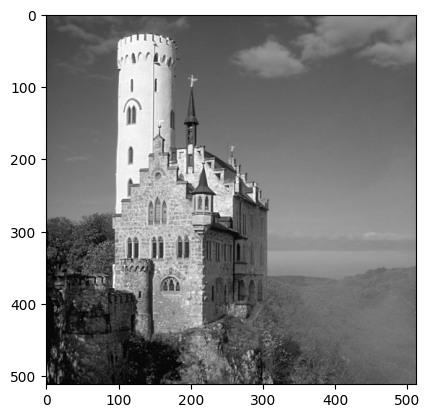

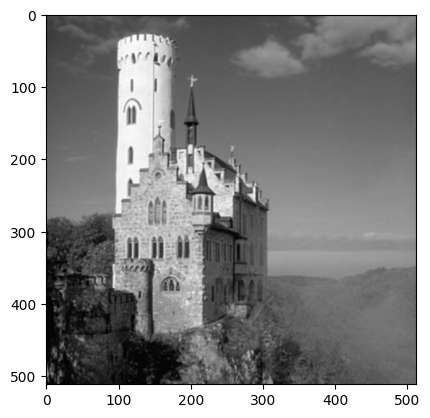

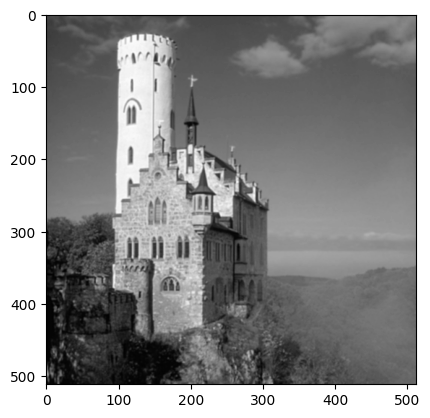

In [8]:
import time

Icastillo = cv2.imread("./src/Lichtenstein_img_processing_test.png", 0)
print(M)
print(h)

start = time.process_time()
# Código filtrado
Ifilt1 = cv2.filter2D(Icastillo, -1, np.flip(M))
end =  time.process_time()
print("Tiempo filtro completo =\n", end - start, "segundos") 

start = time.process_time()
# Código filtrado
Ih1 = cv2.filter2D(Icastillo, -1, np.flip(h.reshape(3,1)))
Ifilt2 = cv2.filter2D(Ih1, -1, np.flip(h.reshape(1, 3)))
end =  time.process_time()
print("Tiempo filtro separable =\n", end - start, "segundos") 


plt.figure()
plt.imshow(Icastillo, cmap="gray")

plt.figure()
plt.imshow(Ifilt1, cmap="gray")

plt.figure()
plt.imshow(Ifilt2, cmap="gray")

Como se puede ver, para un filtro $3\times 3$ la diferencia de tiempo del filtro separable con respecto al completo no es muy grande. Incluso puede ser que tarde más el separable por la sobrecarga necesaria para realizar 2 llamadas a función con respecto a una única llamada.

## **Operaciones de suavizado (blur o filtrado paso bajo)**

En este apartado vamos a experimentar con algunas de las operaciones de filtrado espacial para suavizado vistas en clase.

Lo primero que haremos es probar un **filtro de suavizado tipo caja** o **box filter**: una matriz llena de unos (hay que recordar dividir los elementos de la matriz  por la suma de los elementos del filtro). 

Ejecutaremos un filtro grande utilizando el hecho de que es separable y compararemos el filtrado con el kernel completo y con los dos separados:

Tiempo filtro completo =
 0.010915666999999907 segundos
Tiempo filtro separable =
 0.00237246599999974 segundos


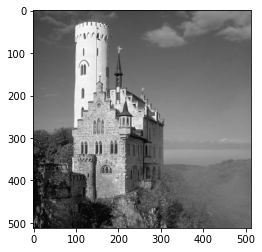

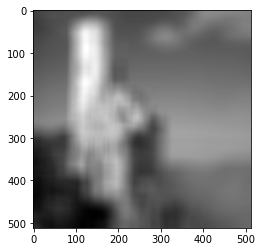

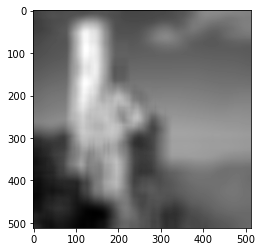

In [ ]:
import time

Icastillo = cv2.imread("Lichtenstein_img_processing_test.png", 0)

size = 41
M2_box = np.ones((size, size))          
M2_box /= M2_box.sum()
h2_box = (1/size) * np.ones((size, 1))
h2_box /= h2_box.sum()

start = time.process_time()
# Código filtrado
Icastillo_box = cv2.filter2D(Icastillo, -1, np.flip(M2_box))
end =  time.process_time()
print("Tiempo filtro completo =\n", end - start, "segundos") 

start = time.process_time()
# Código filtrado
Ih1 = cv2.filter2D(Icastillo, -1, np.flip(h2_box.reshape(size, 1)))
Icastillo_box2 = cv2.filter2D(Ih1, -1, np.flip(h2_box.reshape(1, size)))
end =  time.process_time()
print("Tiempo filtro separable =\n", end - start, "segundos") 

plt.figure()
plt.imshow(Icastillo, cmap="gray")

plt.figure()
plt.imshow(Icastillo_box, cmap="gray")

plt.figure()
plt.imshow(Icastillo_box2, cmap="gray")

Como hemos visto ahora sí que se nota que el tiempo de ejecución del separable es mucho mejor que el filtro completo. Mucho más si incrementamos el tamaño de las imágenes (pensar en imágenes en HD o 4K).


En clase hemos visto que el uso del box filter tiene algunos problemas que arregla **filtro Gaussiano**. Vamos a utilizar ahora la función cv2.GaussianBlur de OpenCV para el suavizado. Tendremos que calcular primero el tamaño del filtro gaussiano para que "quepa" en el 99,7% de la densidad de probabilidad de la Gaussiana (distribución normal) de desviación típica dada, $sigma$. En calase hemos visto que tenemos que utilizar la ecuación: $n= 1 + 3\sigma$, siendo $\sigma$ la desviación típica.

Text(0.5, 1.0, 'Icastillo_gaussblur')

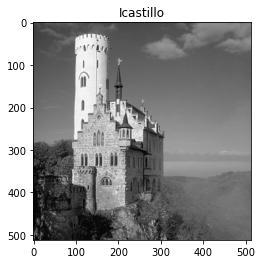

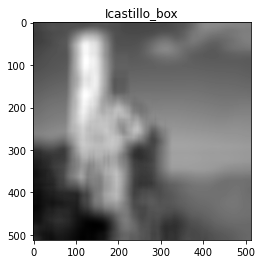

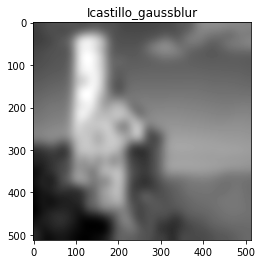

In [ ]:
sigma = 12
ksize = 1 + 2 * 3 * sigma

Icastillo_gaussblur = cv2.GaussianBlur(Icastillo, (ksize, ksize), sigma)

plt.figure()
plt.imshow(Icastillo, cmap="gray")
plt.title("Icastillo")

plt.figure()
plt.imshow(Icastillo_box, cmap="gray")
plt.title("Icastillo_box")

plt.figure()
plt.imshow(Icastillo_gaussblur, cmap="gray")
plt.title("Icastillo_gaussblur")


Como se puede ver el suavizado de tipo caja genera unas líneas alrededor de los bordes que no genera el el gaussiano. Volveremos a este problema cuando veamos el filtrado en el dominio de la frecuencia.

`cv2.GaussianBlur` es una función que nos permite ahorrarnos el trabajo de calcular nosotros el filtro gaussiano. Sin embargo, en algunas ocasiones necesitamos tener más control sobre la máscara de convolución que usaremos.

A continuación vamos a construir nuestro propio filtro Gaussiano con lo que hemos visto en clase. 

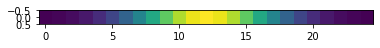

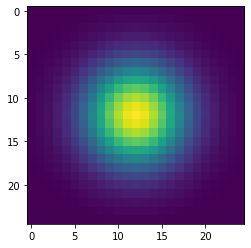

In [ ]:
sigma = 4
ksize = 1 + 2 * 3 * sigma

# Utilizamos esta función de OpenCV para conseguir una máscara gaussiana 
# de 1 dimensión
hgauss=cv2.getGaussianKernel(ksize, sigma)
plt.imshow(hgauss.reshape(1, ksize))

# Como el kernel gaussiano de 2 dimensiones es separable se puede recuperar
# a partir de los kernels de una dimensión mediante multiplicación de matrices 
# El operador @ es el de multiplicación de matrices, el * en numpy es el de 
# multiplicaciṕn elemento a elemento de dos np.arrays (deben de tener el mismo shape).
plt.figure()
Mgauss = hgauss.reshape(ksize, 1) @ hgauss.reshape(1, ksize)
Mgauss /= Mgauss.sum()
plt.imshow(Mgauss)

Construyamos ahora una máscara Gaussiana con una capacidad de suavizado parecida a la del ejemplo del box filter $41\times 41$:


Text(0.5, 1.0, 'Icastillo_gauss')

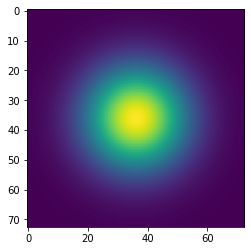

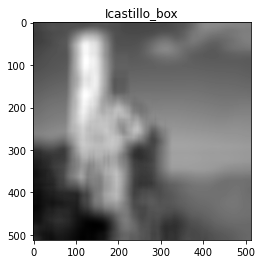

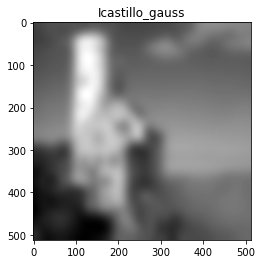

In [ ]:
sigma = 12
ksize = 1 + 2 * 3 * sigma
hgauss=cv2.getGaussianKernel(ksize, sigma)
Mgauss = hgauss.reshape(ksize, 1) @ hgauss.reshape(1, ksize)
Mgauss /= Mgauss.sum()
plt.imshow(Mgauss)

Icastillo_gauss = cv2.filter2D(Icastillo, -1, Mgauss)

#plt.imshow(Icastillo, cmap="gray")
plt.figure()
plt.imshow(Icastillo_box, cmap="gray")
plt.title("Icastillo_box")
plt.figure()
plt.imshow(Icastillo_gauss, cmap="gray")
plt.title("Icastillo_gauss")


Algo interesante que se puede hacer con el filtro gaussiano es el hacer más fuerte el suavizado en una dirección que en otra (convirtiendo la gaussiana elíptica en lugar de circular):

Text(0.5, 1.0, 'Icastillo_gauss2')

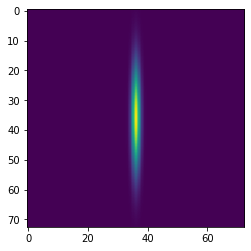

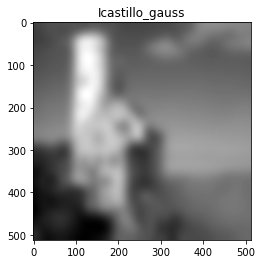

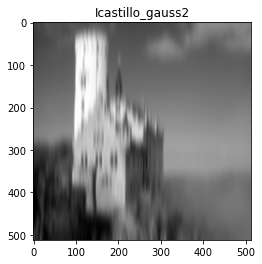

In [ ]:
sigma1 = 12
sigma2 = 1
ksize = 1 + 2 * 3 * max(sigma1, sigma2)

hgauss1=cv2.getGaussianKernel(ksize, sigma1)
hgauss2=cv2.getGaussianKernel(ksize, sigma2)
Mgauss2 = hgauss1.reshape(ksize, 1) @ hgauss2.reshape(1, ksize)
Mgauss2 /= Mgauss2.sum()

plt.figure()
plt.imshow(Mgauss2)

Icastillo_gauss2 = cv2.filter2D(Icastillo, -1, Mgauss2)

#plt.imshow(Icastillo, cmap="gray")
plt.figure()
plt.imshow(Icastillo_gauss, cmap="gray")
plt.title("Icastillo_gauss")
plt.figure()
plt.imshow(Icastillo_gauss2, cmap="gray")
plt.title("Icastillo_gauss2")

Como se puede ver Icastillo_gauss2 tiene el suavizado fuerte a lo largo de la dirección vertical y parece que se ha producido al mover la cámara en esa dirección mientras se tomaba la fotografía.

## Operaciones de detección de bordes (o filtrado paso alto)

Un borde es una zona de la imagen con un cambio gradual en el 
nivel de gris de la imagen en los bordes:

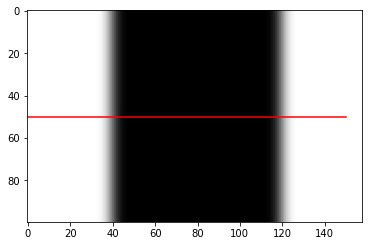

In [ ]:
# Primero creamos la imagen con dos "escalones" en los niveles de gris: blanco a negro y negro a blanco 
I = np.uint8(255*np.ones((100, 150)))
I[:, 40:120] = 0

# A continuación suavizamos la imagen para que tenga un cambio gradual en los niveles de gris (en lugar de brusco):
sigma = 3
ksize = 1 + 6*sigma
I = cv2.GaussianBlur(I, (ksize, ksize), sigma)

plt.imshow(I, cmap="gray")
plt.plot([0, 150], [50, 50], '-r') # pintamos una línea roja en horizontal

El perfil de niveles de gris a lo largo de esa línea roja es el siguiente:

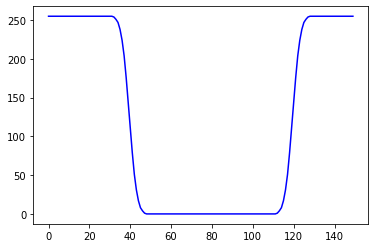

In [ ]:
plt.plot(I[50,:], '-b')

Calculamos la derivada numérica en horizontal de la imagen con un filtrado:

[[ 0.5  0.  -0.5]]


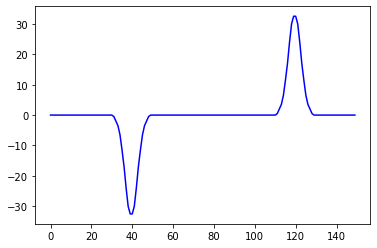

In [ ]:
kernel_deriv = (1/2)*(np.array([[1, 0, -1]]))
print(kernel_deriv)
Ideriv = cv2.filter2D(I, cv2.CV_32F, np.flip(kernel_deriv)) # Hacemos una convolución y devolvemos imagen dtype=float

# Enseñamos la derivada a lo largo de la misma fila que antes
plt.plot(Ideriv[50,:], '-b')

In [ ]:
# Normalizamos la derivada (floats negativos y positivos) como una imagen 
# llevando el mínimo negativo a 0 y el máximo positivo a 255
def normalizar_img_derivada(Id):
   return np.uint8(255*(Id-Id.min())/(Id.max()-Id.min()))    

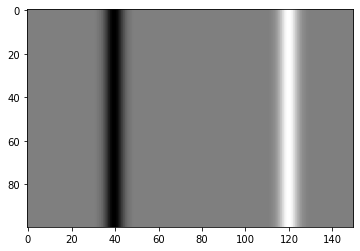

In [ ]:
Ideriv_normalizada = normalizar_img_derivada(Ideriv)
plt.imshow(Ideriv_normalizada, cmap="gray")

Ahora podemos hacer la derivada horizontal y vertical de una imagen ejemplo:

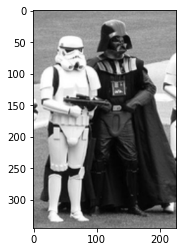

In [ ]:
Ivader = cv2.imread("star_wars.png", 0)
plt.imshow(Ivader, cmap="gray")

In [ ]:
# Ejercicio:
# Derivada con respecto a la coordenada horizontal ("derivada horizontal")



In [ ]:
# Ejercicio:
# Derivada con respecto a la coordenada vertical ("derivada vertical")



### ¿Cómo afecta el ruido a la derivada?
En primero lugar vamos a ver qué pasa en señales de 1 dimensión (luego veremos qué pasa con imágenes.

Vamos a generar una función (o señal) de 1 dimensión con un escalón:

(100, 2000)


Text(0.5, 1.0, 'nivel de gris de I a lo largo de una fila')

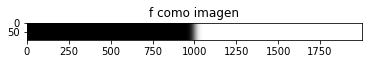

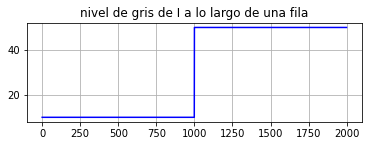

In [ ]:
func_domain_size=2000
I = np.uint8(10*np.ones((100, func_domain_size)))
print(f.shape)
I[:, round(func_domain_size/2):func_domain_size] = 50
plt.imshow(f, cmap="gray")
plt.title("f como imagen")

# Y enseñamos el perfil de grises a lo largo de la fila de índice 50
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(I[50,:], '-b')
plt.grid()
plt.title("nivel de gris de I a lo largo de una fila")

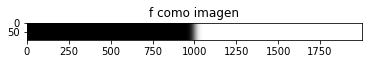

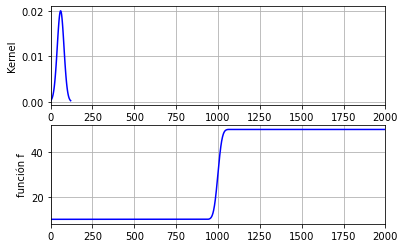

In [ ]:
# Suavizamos un poco el escalón para que sea un "borde" suave
sigma = 20
ksize_gauss = 1 + 6*sigma
kernel_gauss = cv2.getGaussianKernel(ksize_gauss, sigma).reshape(1, ksize_gauss)
kernel_gauss /= kernel_gauss.sum()
f = cv2.filter2D(I, cv2.CV_32F, np.flip(kernel_gauss))
plt.imshow(f, cmap="gray")
plt.title("f como imagen")

fig = plt.figure()
ax1 = plt.subplot(2, 1, 1)
plt.plot(kernel_gauss[0,:], '-b')
ax1.set_xlim([0, func_domain_size])
plt.ylabel("Kernel")
plt.grid()

ax1 = plt.subplot(2, 1, 2)
plt.plot(f[50,:], '-b')
ax1.set_xlim([0, func_domain_size])
plt.ylabel("función f")
plt.grid()

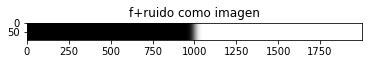

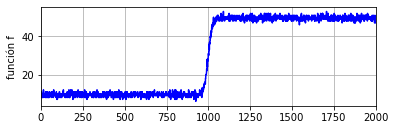

In [ ]:
# Ahora generamos ruido gaussiano y se lo sumamos a la señal f
sigma_ruido = 1
media_ruido = 0

ruido = np.random.normal(media_ruido, sigma_ruido, f.shape)
f_ruido = np.uint8(f + ruido)
plt.imshow(f, cmap="gray")
plt.title("f+ruido como imagen")

plt.figure()
ax1 = plt.subplot(2, 1, 1)
plt.plot(f_ruido[50,:], '-b')
ax1.set_xlim([0, func_domain_size])
plt.ylabel("función f")
plt.grid()

Veamos qué ocurre ahora si hacemos la derivada de la señal con ruido gaussiano incorporado:

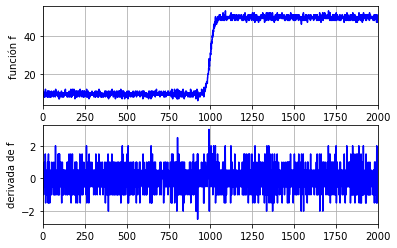

In [ ]:
# Calculamos la derivada horizontal de la señal con ruido utilizando una convolución
kernel_deriv = np.float32((1/2)*(np.array([[1, 0, -1]])))
f_ruido_deriv = cv2.filter2D(f_ruido, cv2.CV_32F, np.flip(kernel_deriv))

# Enseñamos la derivada a lo largo de la misma fila que antes
plt.figure()
ax = plt.subplot(2, 1, 1)
plt.plot(f_ruido[50,:], '-b')
ax.set_xlim([0, func_domain_size])
plt.ylabel("función f")
plt.grid()

ax = plt.subplot(2, 1, 2)
plt.plot(f_ruido_deriv[50,:], '-b')
ax.set_xlim([0, func_domain_size])
plt.ylabel("derivada de f")
plt.grid()

Como se puede ver, la derivada se ve afectada por el ruido y no se parece a la derivada que uno esperaría.

Sin embargo, si primero atenuamos el ruido con un suavizado gaussiano, tendremos una derivada como esperábamos:

Text(0, 0.5, '$\\frac{d}{d x} (g * f)$')

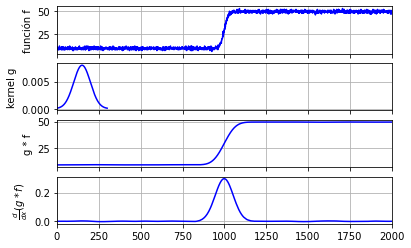

In [ ]:
# Atenuamo el ruido con un suavizado
sigma = 50
ksize = 1 + 6*sigma
kernel_gauss_ruido = cv2.getGaussianKernel(ksize, sigma).reshape(1, ksize)
kernel_gauss_ruido /= kernel_gauss_ruido.sum()
f_ruido_smooth = cv2.filter2D(f_ruido, cv2.CV_32F, np.flip(kernel_gauss_ruido))

# Calculamos la derivada horizontal de la señal con ruido utilizando una convolución
kernel_deriv = np.float32((1/2)*(np.array([[1, 0, -1]])))
f_ruido_smooth_deriv = cv2.filter2D(f_ruido_smooth, cv2.CV_32F, np.flip(kernel_deriv))

# Enseñamos la derivada a lo largo de la misma fila que antes
ax = plt.subplot(4, 1, 1)
plt.plot(f_ruido[50,:], '-b')
ax.set_xlim([0, func_domain_size])
plt.xticks(color="w")
plt.ylabel("función f")
plt.grid()

ax = plt.subplot(4, 1, 2)
plt.plot(kernel_gauss_ruido[0,:], '-b')
plt.grid()
ax.set_xlim([0, func_domain_size])
plt.xticks(color="w")
plt.ylabel(r"kernel g")

ax = plt.subplot(4, 1, 3)
plt.plot(f_ruido_smooth[50,:], '-b')
plt.grid()
ax.set_xlim([0, func_domain_size])
plt.xticks(color="w")
plt.ylabel(r"g * f")

ax = plt.subplot(4, 1, 4)
plt.plot(f_ruido_smooth_deriv[50,:], '-b')
plt.grid()
ax.set_xlim([0, func_domain_size])
plt.ylabel(r"$\frac{d}{d x} (g * f)$")

Pero claro, aquí hemos tenido que hacer dos filtrados: un suavizado gaussiano y luego la derivada.

Como la convolución es asociativa podemos construir un único filtro con una convolución y pasar ese filtro una única vez:

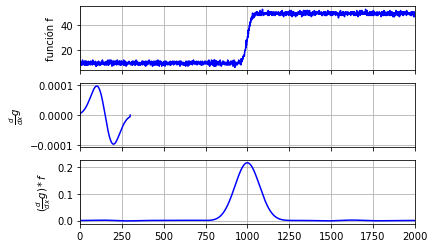

In [ ]:
# Convolucionamos el kernel de derivada con el gaussiano que elimina el ruido
kernel_DoG = cv2.filter2D(kernel_gauss_ruido, -1, np.flip(kernel_deriv))

# Aplicamos el nuevo kernel a nuestra (imagen) f
f_ruido_smooth_deriv2 = cv2.filter2D(f_ruido_smooth, cv2.CV_32F, np.flip(kernel_DoG))

# Enseñamos la derivada a lo largo de la misma fila que antes
ax = plt.subplot(3, 1, 1)
ax.set_xlim([0, func_domain_size])
plt.plot(f_ruido[50,:], '-b')
plt.ylabel("función f")
plt.xticks(color="w")
plt.grid()

ax = plt.subplot(3, 1, 2)
ax.set_xlim([0, func_domain_size])
plt.plot(kernel_DoG[0,:], '-b')
plt.ylabel(r"$\frac{d}{d x} g $")
plt.xticks(color="w")
plt.grid()

ax = plt.subplot(3, 1, 3)
ax.set_xlim([0, func_domain_size])
plt.plot(f_ruido_smooth_deriv2[50,:], '-b')
plt.ylabel(r"$(\frac{d}{d x} g) * f$")
plt.grid()

## Filtros de derivada de un kernel de suavizado

Como ya hemos visto, es muy imporante suavizar antes de realizar la derivada para controlar el tamaño de los bordes que nos interesan.

### Filtros de Prewitt

El filtro de Prewitt suaviza con un filtro de caja en la dirección ortogonal a la de la derivada:

In [ ]:
# Kernels que vamos a utilizar
box_kernel3 = (1/3) * np.ones((3,))
gauss_kernel3 = (1/4) * np.array([[1, 2, 1]])
deriv_kernel = (1/2)*(np.array([[1, 0, -1]]))

# Prewitt para derivada horizontal usando convolución (tenemos que rellenar con ceros el kernel columna)
box_kernel3_pad = np.zeros((3, 5))
box_kernel3_pad[:, 2] = box_kernel3
print("box_kernel3_pad=\n", box_kernel3_pad)
prewitt_hz1 = cv2.filter2D(box_kernel3_pad, -1, np.flip(deriv_kernel))
prewitt_hz = prewitt_hz1[:,1:4].copy()
print("prewitt_hz=\n", prewitt_hz)

# Prewitt para derivada vertical usando convolución (tenemos que rellenar con ceros el kernel columna)
box_kernel3_pad = np.zeros((5, 3))
box_kernel3_pad[2, :] = box_kernel3
print("box_kernel3_pad=\n", box_kernel3_pad)
prewitt_vt1 = cv2.filter2D(box_kernel3_pad, -1, np.flip(deriv_kernel.reshape(3,1)))
prewitt_vt = prewitt_vt1[1:4,:].copy()

print("prewitt_vt=\n", prewitt_vt)

box_kernel3_pad=
 [[0.         0.         0.33333333 0.         0.        ]
 [0.         0.         0.33333333 0.         0.        ]
 [0.         0.         0.33333333 0.         0.        ]]
prewitt_hz=
 [[ 0.16666667  0.         -0.16666667]
 [ 0.16666667  0.         -0.16666667]
 [ 0.16666667  0.         -0.16666667]]
box_kernel3_pad=
 [[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
prewitt_vt=
 [[ 0.16666667  0.16666667  0.16666667]
 [ 0.          0.          0.        ]
 [-0.16666667 -0.16666667 -0.16666667]]


In [ ]:
# Ejercicio:
# Aplicar Prewitt horizontal y vertical a la imagen

### Filtros de Sobel

El filtro de Sobel suaviza con un filtro gaussiano en la dirección ortogonal a la de la derivada:

In [ ]:
# Ejercicio: 
# Comprobar que el filtro de Sobel se obtiene por la convolución de los dos filtros (como hemos hecho con Prewitt)


In [ ]:
# Ejercicio:
# Aplicar Sobel horizontal y vertical a la imagen

### Filtros Derivada de una Gaussiana

En este caso hacemos una máscara gaussiana completa (no únicamente en la dirección ortogonal a la derivada) y derivamos:

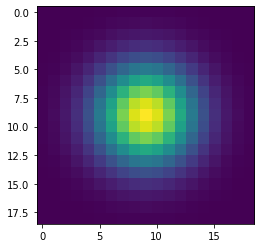

In [ ]:
# Creamos la máscara (o kernel) de convolución gaussiana
sigma = 3
k_size = 3 * 2 * sigma + 1
gaussian = cv2.getGaussianKernel(k_size, sigma)
gaussian = gaussian * gaussian.reshape(1, gaussian.shape[0])
gaussian /= gaussian.sum()
plt.figure()
plt.imshow(gaussian)
plt.show()

Text(0.5, 1.0, 'derivada vertical de una gaussiana')

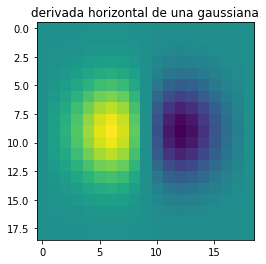

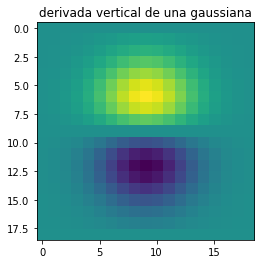

In [ ]:
# Creamos el kernel de derivada
deriv_kernel = (1/2)*(np.array([[1, 0, -1]]))

# Hacemos la derivada horizontal de la Gaussiana
deriv_gauss_hz = cv2.filter2D(gaussian, -1, np.flip(deriv_kernel))
plt.figure()
plt.imshow(deriv_gauss_hz)
plt.title("derivada horizontal de una gaussiana")

# Hacemos la derivada vertical de la Gaussiana
deriv_gauss_vt = cv2.filter2D(gaussian, -1, np.flip(deriv_kernel.T))
plt.figure()
plt.imshow(deriv_gauss_vt)
plt.title("derivada vertical de una gaussiana")

In [ ]:
# Ejercicio:
# Aplicar las máscaras derivadas de una gaussiana con diferentes sigmas en la gaussiana

## Derivada segunda y operador Laplaciana

En esta sección vamos a ver qué podemos hacer con la derivada segunda de una imagen

### Derivada segunda como una convolución

En esta sección vamos a ver qué podemos hacer con la derivada segunda de una imagen

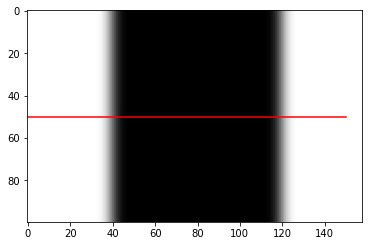

In [ ]:
# Primero creamos la imagen con dos "escalones" en los niveles de gris: blanco a negro y negro a blanco 
I = np.uint8(255*np.ones((100, 150)))
I[:, 40:120] = 0

# A continuación suavizamos la imagen para que tenga un cambio gradual en los niveles de gris (en lugar de brusco):
sigma = 3
ksize = 1 + 6*sigma
I = cv2.GaussianBlur(I, (ksize, ksize), sigma)

plt.figure()
plt.imshow(I, cmap="gray")
plt.plot([0, 150], [50, 50], '-r') # pintamos una línea roja en horizontal

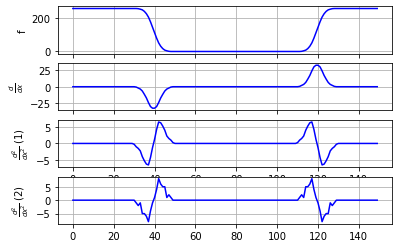

In [ ]:
# Podemos calcular la derivada segunda aplicando la derivada 2 veces (en horizontal):
kernel_deriv = (1/2)*(np.array([[1, 0, -1]]))
Ideriv = cv2.filter2D(I, cv2.CV_32F, np.flip(kernel_deriv)) # Hacemos una convolución y devolvemos imagen dtype=float
Iseg_deriv = cv2.filter2D(Ideriv, cv2.CV_32F, np.flip(kernel_deriv)) # Hacemos una convolución y devolvemos imagen dtype=float

# También usando el kernel de derivada segunda
kernel_seg_deriv = (np.array([[1, -2, 1]]))
Iseg_deriv2 = cv2.filter2D(I, cv2.CV_32F, np.flip(kernel_seg_deriv)) # Hacemos una convolución y devolvemos imagen dtype=float


# Mostrar resultados
plt.imshow(f, cmap="gray")
plt.title("f como imagen")

ax1 = plt.subplot(4, 1, 1)
plt.plot(I[50,:], '-b')
plt.xticks(color="w")
plt.ylabel("f")
plt.grid()

ax1 = plt.subplot(4, 1, 2)
plt.plot(Ideriv[50,:], '-b')
plt.xticks(color="w")
plt.ylabel(r"$\frac{d}{d x}$")
plt.grid()

ax1 = plt.subplot(4, 1, 3)
plt.plot(Iseg_deriv[50,:], '-b')
plt.ylabel(r"$\frac{d^2}{d x^2}$ (1)")
plt.grid()

ax1 = plt.subplot(4, 1, 4)
plt.plot(Iseg_deriv2[50,:], '-b')
plt.ylabel(r"$\frac{d^2}{d x^2}$ (2)")
plt.grid()

Los bordes están en el máximo o mínimo de la derivada primera y en los cruces con cero de la derivada segunda.

In [ ]:
# Ejercicio:
# Aplicar las máscaras de derivada segunda en diferences imágenes

### Operador Laplaciano (Laplacian) y Laplaciana de una Gaussiana

En esta sección vamos a ver qué podemos hacer con el operador Laplaciana y cómo usarlo con un filtro gaussiano previo. El operador Laplaciana se define como la suma de las derivadas segundas en horizontal y vertical:

$$\nabla^2 f = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}$$

y su aproximación discreta genera la máscara de convolución:

$$\left( \begin{matrix} 0 & 1 & 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0\end{matrix}\right)$$

uint8


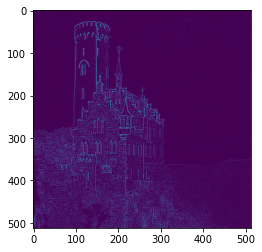

In [ ]:
laplacian_kernel = np.array([[0, 1, 0], 
                             [1, -4, 1], 
                             [0, 1, 0]])

Ilaplacian = cv2.filter2D(Icastillo, -1, np.flip(laplacian_kernel))
print(Ilaplacian.dtype)
plt.imshow(Ilaplacian)                          

Como hemos hecho antes, podemos pasar un filtro de suavizado previo a la derivada para atenuar el ruido. En este caso, y usando la propiedad asociativa podemos aplicar el kernel **Laplaciana de una Gaussiana**:

(19, 19)
(19, 19)


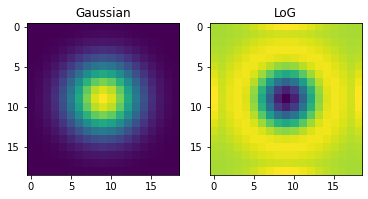

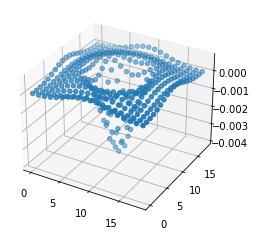

In [ ]:
# Creamos la máscara (o kernel) de convolución gaussiana
sigma = 3
k_size = round(3 * 2 * sigma + 1)
gaussian = cv2.getGaussianKernel(k_size, sigma)
gaussian = gaussian * gaussian.reshape(1, gaussian.shape[0])
gaussian /= gaussian.sum()

LoG_kernel = cv2.filter2D(gaussian, -1, laplacian_kernel)

# Mostrar en 2D el kernel LoG
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(gaussian)
plt.title("Gaussian")
plt.subplot(1, 2, 2)
plt.imshow(LoG_kernel)
plt.title("LoG")

# Mostrar el kernel LoG en 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = plt.axes(projection='3d')
counter = range(LoG_kernel.shape[0])
x,y = np.meshgrid(counter, counter)
print(x.shape)
print(LoG_kernel.shape)
xx = x [:]
yy = y[:]
zz = LoG_kernel[:]
ax.scatter3D(xx, yy, zz, cmap='Greens');

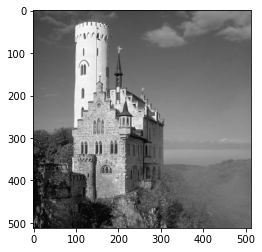

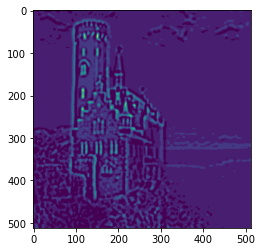

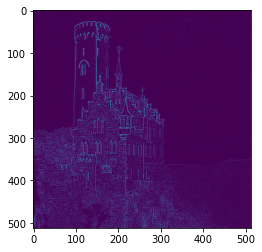

In [ ]:
# Lo aplicamos a una imagen
ILoG= cv2.filter2D(Icastillo, -1, np.flip(LoG_kernel))

Ilaplacian= cv2.filter2D(Icastillo, -1, np.flip(laplacian_kernel))

plt.figure()
plt.imshow(Icastillo, cmap="gray")          
plt.figure()
plt.imshow(ILoG)   
plt.figure()
plt.imshow(Ilaplacian)   

### Detección de bordes con el vector gradiente

En esta sección vamos a ver como calcular y utilizar el vector gradiente para detectar bordes

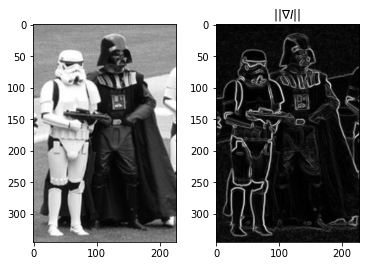

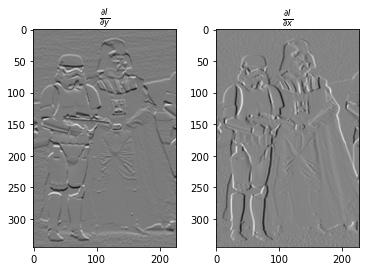

In [ ]:
kernel_deriv = (1/2)*(np.array([[1, 0, -1]]))

# Derivada horizontal
Ix = cv2.filter2D(Ivader, cv2.CV_32F, np.flip(kernel_deriv.reshape(1, 3))) 
Iy = cv2.filter2D(Ivader, cv2.CV_32F, np.flip(kernel_deriv.reshape(3, 1))) 
norma_gradiente = np.sqrt(Ix*Ix + Iy*Iy)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(Ivader, cmap="gray")          
plt.subplot(1,2,2)
plt.title(r"$||\nabla I||$")
plt.imshow(norma_gradiente, cmap="gray")  

plt.figure()
plt.subplot(1,2,2)
plt.title(r"$\frac{\partial I}{\partial x}$")
plt.imshow(normalizar_img_derivada(Ix), cmap="gray")  
plt.subplot(1,2,1)
plt.title(r"$\frac{\partial I}{\partial y}$")
plt.imshow(normalizar_img_derivada(Iy), cmap="gray")  
         
    
    

### Detección de bordes con el vector gradiente + Canny

En esta sección vamos a ver como mejorar los bordes dados por el vector gradiente con el algoritmo de Canny

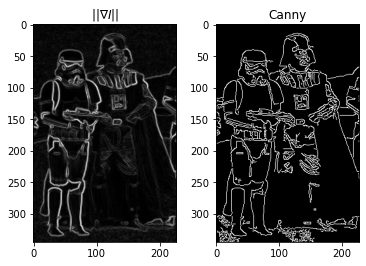

In [ ]:
Icanny = cv2.Canny(Ivader,10,200)

plt.figure()
plt.subplot(1,2,2)
plt.imshow(Icanny, cmap="gray")          
plt.title("Canny")

plt.subplot(1,2,1)
plt.title(r"$||\nabla I||$")
plt.imshow(norma_gradiente, cmap="gray") 
